# KerasNLP starter notebook Disaster Tweets

In [1]:
!pip install keras-core --upgrade 
!pip install -q keras-nlp --upgrade

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.9/851.9 kB 11.9 MB/s eta 0:00:00a 0:00:01


In [2]:
# libararies
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_core as keras
import keras_nlp

from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Tensorflow version: ", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Using TensorFlow backend
Tensorflow version:  2.12.0
KerasNLP version: 0.6.1


# About the Dataset

Train and Test

They contain
- id
- keyword: A keyword from that tweet.(may be black)
- location: The location the tweet was sent from(may be black)
- text: The text of a tweet
- target: 1 if the tweet is a real disaster or 0 if not


In [3]:
!ls -lh '/kaggle/input/nlp-getting-started'

total 1.4M
-rw-r--r-- 1 nobody nogroup  23K Dec  2  2020 sample_submission.csv
-rw-r--r-- 1 nobody nogroup 411K Dec  2  2020 test.csv
-rw-r--r-- 1 nobody nogroup 965K Dec  2  2020 train.csv


In [4]:
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [5]:
print(f"Training Set Shape = {df_train.shape}")
print(f"Training Set Memory Usage = {df_train.memory_usage().sum() / 1024**2:.2f} MB")
print(f"Testing Set Shape = {df_test.shape}")
print(f"Testing Set Memory Usage = {df_test.memory_usage().sum() / 1024**2:.2f} MB")

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Testing Set Shape = (3263, 4)
Testing Set Memory Usage = 0.10 MB


In [6]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Explore the Dataset

In [8]:
df_train['length'] = df_train.text.apply(lambda x : len(x))
df_test['length'] = df_train.text.apply(lambda x: len(x))

In [9]:
print("Train Length Stat")
print(df_train['length'].describe())
print()

print("Test Lenght Stat")
print(df_test['length'].describe())


Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Lenght Stat
count    3263.000000
mean      100.581367
std        34.308158
min         7.000000
25%        77.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64


## Preprocessing the Data

In [46]:
# settings

BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT  = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES) * TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [47]:
from sklearn.model_selection import train_test_split
X = df_train['text']
y = df_train['target']

X_train,X_val, y_train, y_val = train_test_split(X,y,
                                                test_size = VAL_SPLIT,
                                                random_state = 42)




## Loading a DistilBERT model from kerasNLP

In [48]:
# laod a Distil model.
preset = 'distil_bert_base_en_uncased'

# using a shorter sequence lenght
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset, 
                                                                  sequence_length = 160,
                                                                  name = 'preprocessor_4_tweets')

# pretrained classifier
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                              preprocessor = preprocessor,
                                                              num_classes = 2)
classifier.summary()

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer_2 (DistilBertTokenizer)      │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ distil_bert_backbone_2        │ (None, None, 768)         │  66,362,880 │ padding_mask[0][0],            │
│ (DistilBertBackbone)          │                           │             │ token_ids[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ get_item_3 (GetItem)          │ (None, 768)               │           0 │ distil_bert_backbone_2[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │     590,592 │ get_item_3[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 768)               │           0 │ pooled_dense[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │       1,538 │ classifier_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────┴────────────────────────────────┘

 Total params: 66,955,010 (2.00 GB)

 Trainable params: 66,955,010 (2.00 GB)

 Non-trainable params: 0 (0.00 B)

## Training the Model,finetuning the BERT

In [49]:
# compile
classifier.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits =True),
    optimizer = keras.optimizers.Adam(1e-5),
    metrics = ['accuracy']

) 


In [50]:
# fit
history = classifier.fit(x = X_train, 
                        y = y_train,
                        batch_size =BATCH_SIZE,
                        epochs =EPOCHS,
                        validation_data = (X_val, y_val))
                        

Epoch 1/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 132s 439ms/step - accuracy: 0.7193 - loss: 0.5635 - val_accuracy: 0.8457 - val_loss: 0.3959
Epoch 2/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 48s 252ms/step - accuracy: 0.8473 - loss: 0.3807 - val_accuracy: 0.8391 - val_loss: 0.3895


In [40]:
def DisplayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis = 1),
        display_labels = ['Not Disaster', "Disaster"],
        cmap = plt.cm.Blues
    )
    
    tn,fp,fn,tp = confusion_matrix(y_true,np.argmax(y_pred, axis = 1)).ravel()
    f1_score = tp / (tp +((fn+fp)/2))
    disp.ax_.set_title("Confusion Matrix on" + dataset + " Dataset -- F1 score: " + str(f1_score.round(2)))

191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step


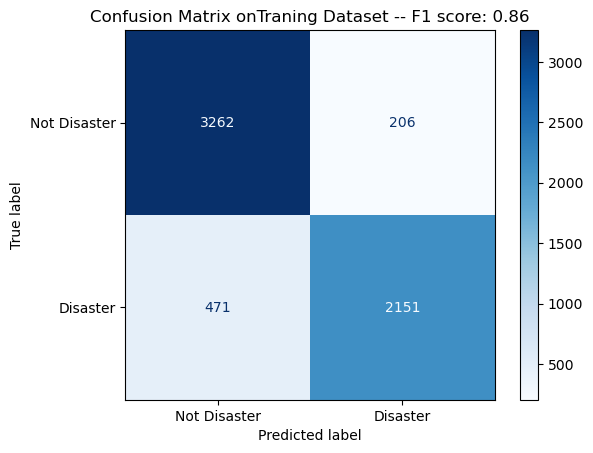

In [53]:
y_pred_train = classifier.predict(X_train)

DisplayConfusionMatrix(y_train, y_pred_train, "Traning")

48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step


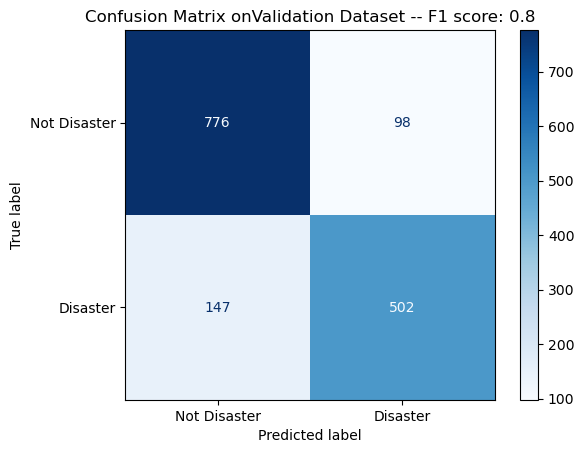

In [54]:
y_pred_val = classifier.predict(X_val)
DisplayConfusionMatrix(y_val, y_pred_val, "Validation")

## Generating the submission file

In [55]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [56]:
X_test = df_test["text"]
sample_submission['target'] = np.argmax(classifier.predict(X_test), axis = 1)


102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step


In [26]:
sample_submission.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.372970
std,3146.427221,0.483668
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


In [57]:
sample_submission.to_csv('submission.csv', index = False)